Centróides exportados para ../data_final/centroides_grande_surface.geojson


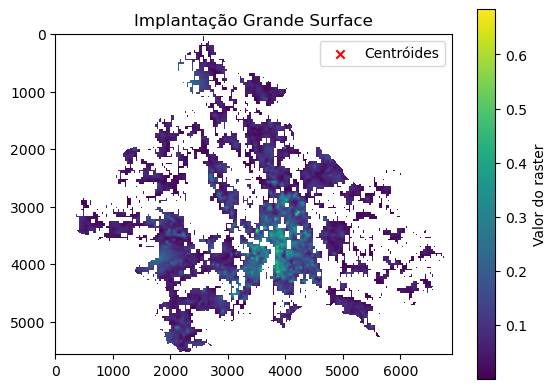

Centróides exportados para ../data_final/centroides_petite_surface.geojson


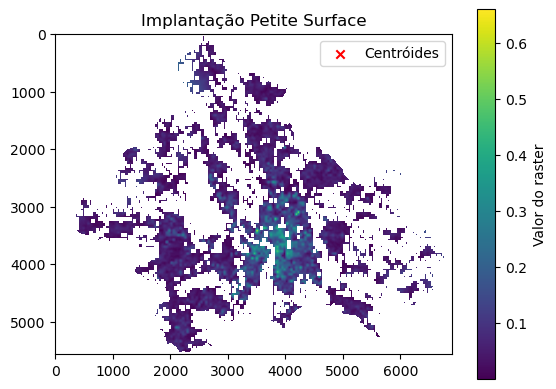

In [1]:
import numpy as np
import rasterio
from scipy.ndimage import label, center_of_mass
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Função para encontrar centróides de zonas de alto potencial
def encontrar_centroides(raster_path, limiar_valor_inicial=60, limiar_valor_minimo=25, num_centroides_minimo=5):
    # Definir distância mínima com base no raster de entrada
    if raster_path.endswith("biocoop_grande_surf.tif"):
        distancia_minima = 5000
    elif raster_path.endswith("biocoop_petite_surf.tif"):
        distancia_minima = 2000
    else:
        raise ValueError("Raster desconhecido. Defina a distância mínima para este raster.")
    
    # Abrir o raster e carregar os dados
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        data = np.where(data == src.nodata, np.nan, data)
        transform = src.transform

    # Função auxiliar para realizar a busca de centróides
    def buscar_centroides(data, limiar, distancia_minima, num_centroides_minimo):
        # Criar uma máscara binária (1 = alta potencial, 0 = baixa potencial)
        binary_mask = np.where(data >= limiar, 1, 0)
        
        # Encontrar zonas conectadas (componentes) na máscara binária
        labeled_array, num_features = label(binary_mask)
        
        # Calcular os centróides de cada zona de alto potencial
        all_centroids = center_of_mass(binary_mask, labeled_array, range(1, num_features + 1))
        
        # Ordenar centróides por valor de potencial (do maior para o menor) usando valores de pixel
        all_centroids = sorted(all_centroids, key=lambda c: data[int(c[0]), int(c[1])], reverse=True)
        
        # Filtrar centróides com distância mínima e garantir ao menos 5 centróides
        filtered_centroids = []
        for centroid in all_centroids:
            if not filtered_centroids:
                filtered_centroids.append(centroid)
            else:
                # Converta os centróides para coordenadas reais
                centroid_coords = np.array([(c[1], c[0]) for c in filtered_centroids])
                new_centroid_coords = np.array([[centroid[1], centroid[0]]])

                # Calcule a distância entre o novo centróide e os já filtrados
                distances = cdist(centroid_coords, new_centroid_coords) * abs(transform[0])  # Multiplica pela resolução
                if np.all(distances >= distancia_minima) or len(filtered_centroids) < num_centroides_minimo:
                    filtered_centroids.append(centroid)

            # Parar ao atingir o número mínimo de centróides
            if len(filtered_centroids) >= num_centroides_minimo:
                break
        
        return filtered_centroids

    # Iniciar com o limiar inicial e buscar centróides até atingir o mínimo necessário ou o limiar mínimo
    limiar_atual = limiar_valor_inicial
    centroides_final = []

    while limiar_atual >= limiar_valor_minimo:
        centroides_final = buscar_centroides(data, limiar_atual, distancia_minima, num_centroides_minimo)
        if len(centroides_final) >= num_centroides_minimo:
            break
        limiar_atual -= 5  # Reduzir o limiar a cada iteração

    # Converter os centróides para coordenadas geográficas reais
    coordenadas_centroides = [(transform * (c[1], c[0])) for c in centroides_final]
    return coordenadas_centroides

# Função para exportar os centróides para um arquivo GeoJSON
def exportar_centroides_geojson(centroides, output_geojson):
    pontos = [Point(x, y) for x, y in centroides]
    gdf = gpd.GeoDataFrame(geometry=pontos, crs="EPSG:3857")  # CRS assumido, ajuste conforme necessário
    gdf.to_file(output_geojson, driver="GeoJSON")
    print(f"Centróides exportados para {output_geojson}")

# Função para exibir o raster e os centróides
def plotar_centroides(raster_path, centroides, title):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        data = np.where(data == src.nodata, np.nan, data)

    plt.imshow(data, cmap="viridis", vmin=np.nanmin(data), vmax=np.nanmax(data))
    plt.colorbar(label="Valor do raster")
    plt.scatter([c[0] for c in centroides], [c[1] for c in centroides], c="red", marker="x", label="Centróides")
    plt.legend()
    plt.title(title)
    plt.show()

# Definir os caminhos dos rasters
rasters = [
    ("../data_final/biocoop_grande_surf.tif", "../data_final/centroides_grande_surface.geojson", "Implantação Grande Surface"),
    ("../data_final/biocoop_petite_surf.tif", "../data_final/centroides_petite_surface.geojson", "Implantação Petite Surface")
]

# Encontrar, exportar e plotar os centróides para cada raster
for raster_path, output_geojson, title in rasters:
    centroides = encontrar_centroides(raster_path)
    exportar_centroides_geojson(centroides, output_geojson)
    plotar_centroides(raster_path, centroides, title)
